🖥  device : cuda:0
Pixel Shape: 512x512
✅ IQ tensor : (1, 2, 1024, 1024)
✅ Model loaded.
✅ Output : (1, 2, 1024, 1024)
🖫 Saved prediction → C:\Users\user\workspace\IqPixelGrid_HSB\IQBF_1024x1024\dclPrediction.npy


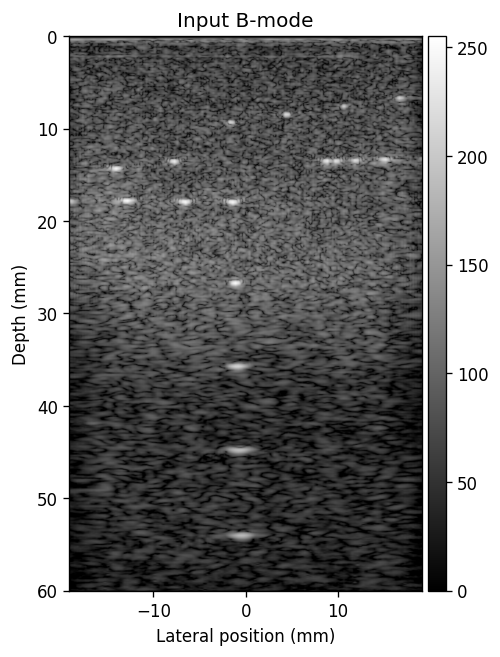

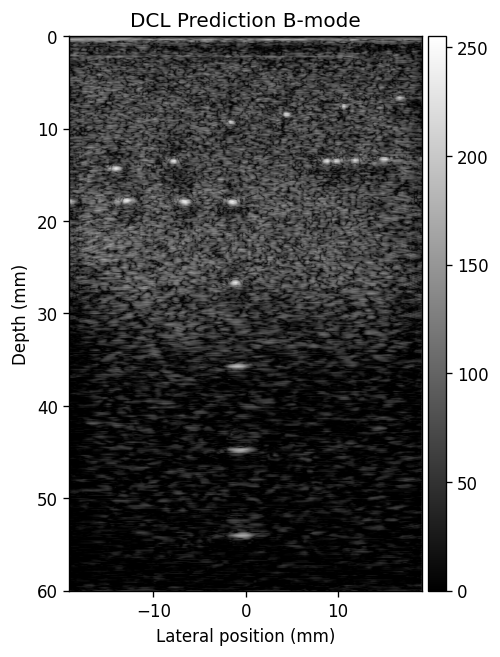

In [8]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import io, numpy as np, torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from model import DCLUNet  
from utils import init_config  


def load_iq_tensor(iq_dir: str, grid_size: int, device="cpu"):
    i_path = os.path.join(iq_dir, "bf_I_real.npy")
    q_path = os.path.join(iq_dir, "bf_Q_image.npy")

    i_data = np.load(i_path).transpose()  
    q_data = np.load(q_path).transpose()
    iq_np  = np.stack([i_data, q_data], axis=0)              
    iq     = torch.tensor(iq_np, dtype=torch.float32, device=device)

    h, w   = iq.shape[-2:]
    pad_h, pad_w = max(grid_size-h, 0), max(grid_size-w, 0)
    iq = F.pad(iq,
               (pad_w//2, pad_w-pad_w//2, pad_h//2, pad_h-pad_h//2),
               mode="constant", value=0.0)
    return iq.unsqueeze(0)                              


def load_dclunet(ckpt_path: str, device="cpu") -> DCLUNet:
    model = DCLUNet().to(device)
    with open(ckpt_path, "rb") as f:
        buffer = io.BytesIO(f.read())
    ckpt = torch.load(buffer, map_location=device)
    state = ckpt.get("model_state_dict", ckpt)
    model.load_state_dict(state, strict=False)
    model.eval()
    return model


@torch.no_grad()
def run_inference(iq: torch.Tensor, model: DCLUNet) -> torch.Tensor:
    return model(iq)


def iq_to_bmode(arr: np.ndarray, dr: int = 60) -> np.ndarray:
    if arr.ndim == 3 and arr.shape[0] == 2:    
        env = np.sqrt(arr[0]**2 + arr[1]**2)
    else:                                    
        env = np.abs(arr)
    env_safe = np.maximum(env, 1e-10)
    log_env  = 20 * np.log10(env_safe / env_safe.max())
    log_env  = np.clip(log_env, -dr, 0)
    img_255  = (log_env + dr) / dr * 255
    return img_255.astype(np.uint8)


def main() -> None:
    GRID_SIZE = 1024
    IQ_DIR = (
        r"C:\Users\user\workspace\IqPixelGrid_HSB\IQBF_1024x1024"
    )
    CKPT_PATH = (
        r"C:\Users\user\workspace\deepcoherenceLearning_HSB\deepcoherence_code"
        r"\datasets\seongbindclcode\model_result\model_best_202532_kaiming_final.pth"
    )
    SAVE_NAME = "dclPrediction.npy"

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("🖥  device :", device)

    cfg = init_config()
    depth_mm = 60  # cfg["depth"] * 1000
    lateral_mm = cfg["View_width"] * 1000

    iq_tensor = load_iq_tensor(IQ_DIR, GRID_SIZE, device)
    print("✅ IQ tensor :", tuple(iq_tensor.shape))

    model = load_dclunet(CKPT_PATH, device)
    print("✅ Model loaded.")

    output = run_inference(iq_tensor, model)
    print("✅ Output :", tuple(output.shape))

    out_np = output.squeeze(0).cpu().numpy()
    save_path = os.path.join(IQ_DIR, SAVE_NAME)
    np.save(save_path, out_np)
    print("🖫 Saved prediction →", save_path)

    lateral_axis = np.linspace(-lateral_mm/2, lateral_mm/2, GRID_SIZE)
    depth_axis = np.linspace(0, depth_mm, GRID_SIZE)

    # (1) 입력 B-mode 출력
    input_img = iq_to_bmode(iq_tensor[0].cpu().numpy())

    fig1, ax1 = plt.subplots(figsize=(6, 6), dpi=120)
    im1 = ax1.imshow(input_img, cmap="gray", vmin=0, vmax=255, origin="upper",
                     extent=[lateral_axis[0], lateral_axis[-1], depth_axis[-1], depth_axis[0]])
    ax1.set_title("Input B-mode")
    ax1.set_xlabel("Lateral position (mm)")
    ax1.set_ylabel("Depth (mm)")

    divider1 = make_axes_locatable(ax1)
    cax1 = divider1.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im1, cax=cax1)
    plt.show()

    # (2) Prediction B-mode 출력
    output_img = iq_to_bmode(out_np)

    fig2, ax2 = plt.subplots(figsize=(6, 6), dpi=120)
    im2 = ax2.imshow(output_img, cmap="gray", vmin=0, vmax=255, origin="upper",
                     extent=[lateral_axis[0], lateral_axis[-1], depth_axis[-1], depth_axis[0]])
    ax2.set_title("DCL Prediction B-mode")
    ax2.set_xlabel("Lateral position (mm)")
    ax2.set_ylabel("Depth (mm)")

    divider2 = make_axes_locatable(ax2)
    cax2 = divider2.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im2, cax=cax2)
    plt.show()


if __name__ == "__main__":
    main()
